# Masks v2.0

## Packages

In [49]:
import numpy as np 
import matplotlib.pyplot as plt 
import phidl.geometry as pg
from phidl import quickplot as qp, set_quickplot_options
from phidl import Device
from itertools import product 
from scipy.optimize import minimize, newton 
from shapely.geometry import Polygon
import flatspin

## Layers

In [50]:
l_layers=2
l_grid = 3
l_design = 4
l_2 = 5
l_wafer=1

## Functions

### ASI model from flatspin

Returns the position and angle of the element of an ASI in Pinwheel model

In [51]:
class CSPinwheel(flatspin.model.SpinIce):
    def __init__(self, cs = 1,**kwargs):
        self.cs = cs

        super().__init__(**kwargs)

    def _init_geometry(self):
        size = self.size
        lattice_spacing = self.lattice_spacing

        pos = flatspin.model.PinwheelSpinIceDiamond(size = size).pos
        angle = flatspin.model.PinwheelSpinIceDiamond(size = size).angle

        pos[:, 0] = pos[:, 0]*self.cs

        return pos, angle

    _vertex_size=(3, 3)

    @property
    def _default_cell_size(self):
        return (self.lattice_spacing/2, self.lattice_spacing/2)

### Element
Creates the stadium shape design as element.

In [52]:
def element(len, wid, lay=l_design): 
    p = wid
    element_parts = pg.rectangle(size=(len, wid-p), layer = lay).movey(0, p/2)
    element_parts << pg.rectangle(size=(len-p, wid), layer = lay).movex(0, p/2)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(0, p/2).movey(0, p/2)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(0, p/2).movey(p/2, wid)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(p/2, len).movey(0, p/2)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(p/2, len).movey(p/2, wid)

    element = pg.union(element_parts, layer = lay)

    element.name = f'element_size-{len}-{wid}_p-{p}'

    if len<wid: 
        return Device()
    return element

### Insert and position element
Insert the element in the positions and angles, also check the separation and adjust the ASI

In [53]:
def device_from_lists(coords, angles, element = None, scale = 1, radians = 1):
    # Adds elements at specified coordinates and angles
    # If no element is specified, adds rectangle of 220 by 80 
    assert len(coords) == len(angles), "Number of coordinates and angles must match"
    coords *= scale
    if radians:
        #convert to deg
        angles = np.degrees(angles)
        
    if not element:
        element = pg.rectangle(size = (220, 80))
    element.move(-element.center) # Center element on (0, 0)
    
    D = Device()
    for coord, angle in zip(coords, angles):
        D << pg.copy(element).rotate(angle).move(coord)

    return D


def stretched_array(sizex = 1, sizey = 1, pitchx = 1, pitchy = 1):
    
    offsetx = pitchx / 2
    offsety = pitchy / 2
    
    xh, xv = np.arange(offsetx, sizex*pitchx, pitchx), np.arange(0, (1+sizex)*pitchx, pitchx)
    yh, yv = np.arange(0, (1+sizey)*pitchy, pitchy), np.arange(offsety, sizey*pitchy, pitchy)

    harray = np.array(np.meshgrid(xh, yh))
    varray = np.array(np.meshgrid(xv, yv))
    
    harray = np.vstack([harray[0].flatten(), harray[1].flatten()]).transpose()
    varray = np.vstack([varray[0].flatten(), varray[1].flatten()]).transpose()

    return harray, varray

def array_angle(array, angle):
    angles = np.ones((len(array), 1))
    angles *= np.deg2rad(angle)
    
    return angles

def return_spacing(pitch, angle,  element=element(220, 80)):
    hpos, vpos = stretched_array(1, 1, 1, 1)
    h_array_angles = array_angle(hpos, angle)
    v_array_angles = array_angle(vpos, angle+90)
    coords = np.concatenate([hpos, vpos])
    angles = np.concatenate([h_array_angles, v_array_angles])
    
    D = device_from_lists(coords, angles, element=element, scale=pitch)
#     plot_device(D, plot_centers=True)
    p0, p1, p2 = [Polygon(p) for p in D.get_polygons()[0:3]]
#     print("dist", p0.distance(p1), p1.distance(p2))
    return p1.distance(p2)

def calc_spacing(spacing, angle, element=element(220, 80), tolerance=0.001):
    s = spacing
    
    scale0 = element.xsize*1.0+element.ysize*0.5
    def scale_func(scale):
        return np.abs(s-return_spacing(scale, angle, element=element))
    scale = newton(scale_func, scale0, rtol=tolerance)
    
    return scale

def calc_matrix_size(lenght, angle, dimen=12e3):
    sin = np.sin(np.deg2rad(angle))
    y=lenght*sin
    # round a number to the next entire
    x = int(np.ceil(dimen/y))
    if x<20:
        x=20
    elif x>100:
        x=100

    return x

def crea_sample(leng, widt, separation, mat_size = (50,50), text_layer=l_layers, des_layer=l_design,angle=45):
    mat_prop=CSPinwheel(size=mat_size, cs=1)
    pos_=mat_prop.pos
    ang_=mat_prop.angle

    new_sample=device_from_lists(pos_, ang_, element(leng,widt, des_layer), scale=calc_spacing(separation,angle,element=element(leng,widt)))
    label=pg.text(f'({leng},{widt},{separation})mat={mat_size}',size=5e2,font="Arial",layer=text_layer,justify='center')
    label.movex(new_sample.xsize/2).movey(new_sample.ysize+500)
    new_sample << label

    return new_sample

def multi_size_sep(sizes, separations, angle, layer, Title):
    MultiDesign = []
    for s in sizes:
        sLe=s[0]
        sWi=s[1]
        for i in separations:
            x=calc_matrix_size(sLe, angle)
            sample=crea_sample(sLe, sWi, i, (x,x), des_layer=layer, angle=angle)
            MultiDesign.append(sample)

    gridded=pg.grid(MultiDesign,spacing=(5e3,5e3),shape=(len(separations),len(sizes)))
    title=pg.text(Title, size=20e3, justify="center", layer=l_layers,font="Arial")
    title.movey(gridded.ymax+20e3).movex(gridded.xsize/2)
    gridded<<title
    gridded.center = (0,0)

    return gridded

### Create sample
Creates a sample with the parameters and label.

## Designs

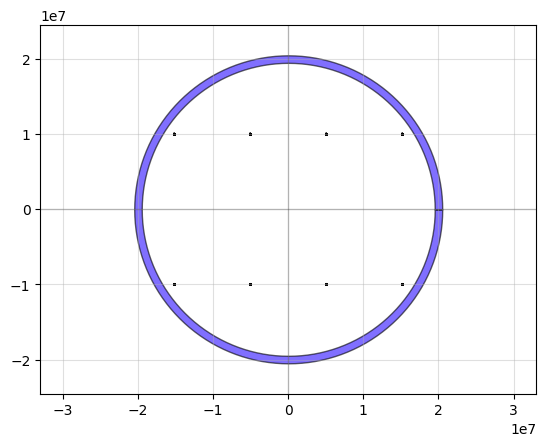

'C:\\masks\\v2.0.gds'

In [54]:
#magnet=element(220,80)
#separation=30
assemble=Device()
Final=Device()

angle=45
sizes=[(880,320), (550,200), (440,160), (330,120), (220,80), (165,60), (110,40)]
separations=[15,20,25,30,35]

wafer=pg.ring(radius=20e6,width=1e6,layer=l_wafer)
wafer.center = (0,0)

design_01=multi_size_sep(sizes, separations, angle, layer=10, Title="Dose 01")
design_02=multi_size_sep(sizes, separations, angle, layer=20, Title="Dose 02")
design_03=multi_size_sep(sizes, separations, angle, layer=30, Title="Dose 03")
design_04=multi_size_sep(sizes, separations, angle, layer=40, Title="Dose 04")
assemble << design_01
assemble << design_02
assemble << design_03
assemble << design_04
assemble.distribute(direction='x', spacing=5e6, separation=True)
assemble.center = (0,0)
assemble.movey(10e6)

assemble2=pg.copy(assemble).movey(-5e6)

Final<<assemble
Final<<assemble2

#sample=crea_sample(220, 80, 30, (50,50), des_layer=40)
#sample2=crea_sample(2200, 800, 15, (10,10), des_layer=50)

qp([Final,wafer])

Final.write_gds(r'C:\masks\v2.0.gds', unit=1e-9, precision=1e-11)